## Feature engineering

### Importación de librerías

Datos y gráficos

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

### Warnings y display de la dataframe

In [2]:
pd.set_option("max_colwidth", 50)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 20)

In [3]:
import warnings

warnings.filterwarnings("ignore")

### Importación de dataframes

In [4]:
directorio_actual = os.getcwd()

In [5]:
df = pd.read_csv(os.path.join(directorio_actual, '..', 'data','raw','df_total.csv'))
df = df.drop(['Unnamed: 0'], axis=1)

### Tratamiento de dataframe

Eliminación de columnas irrelevantes

In [6]:
df = df.drop(['thumbnail','numPhotos','operation','province','has360','country','url','hasVideo','hasPlan','has3DTour','hasStaging','externalReference','labels','newDevelopmentFinished','highlight'],axis=1)
df = df.drop(['topNewDevelopment','superTopHighlight'], axis=1)

Eliminación de registros con anomalías

In [7]:
'''Elimino los registros con anomalías como: 
- Alquiler de habitaciones.
- Alquileres por días.
- Viviendas donde en el tamaño han puesto el de la parcela.'''

df = df.drop([874,543,546,545,547,515,802,210,261,992])

Reset index

In [8]:
'''Reinicio de índices para no tener problema con las llamadas'''
df.reset_index(inplace=True)
df.drop(['index'],axis=1,inplace=True)

Creación de nuevas columnas

In [9]:
'''Aquí vemos las opciones de parking que hay por lo que 
nos quedaremos únicamente con si están o no incluido en el precio
'''
df['parkingSpace'].unique()

array([nan,
       "{'hasParkingSpace': True, 'isParkingSpaceIncludedInPrice': True}",
       "{'hasParkingSpace': True, 'isParkingSpaceIncludedInPrice': False, 'parkingSpacePrice': 150.0}",
       "{'hasParkingSpace': True, 'isParkingSpaceIncludedInPrice': False, 'parkingSpacePrice': 100.0}",
       "{'hasParkingSpace': True, 'isParkingSpaceIncludedInPrice': False, 'parkingSpacePrice': 200.0}",
       "{'hasParkingSpace': True, 'isParkingSpaceIncludedInPrice': False, 'parkingSpacePrice': 160.0}",
       "{'hasParkingSpace': True, 'isParkingSpaceIncludedInPrice': False, 'parkingSpacePrice': 145.0}",
       "{'hasParkingSpace': True, 'isParkingSpaceIncludedInPrice': False, 'parkingSpacePrice': 125.0}",
       "{'hasParkingSpace': True, 'isParkingSpaceIncludedInPrice': False, 'parkingSpacePrice': 130.0}",
       "{'hasParkingSpace': True, 'isParkingSpaceIncludedInPrice': False, 'parkingSpacePrice': 50.0}",
       "{'hasParkingSpace': True, 'isParkingSpaceIncludedInPrice': False, 'parking

In [10]:
'''Creo una columna binaria de parking donde 0, es que no hay parking incluido en el precio
y 1, el parking está incluido en el precio.
Habrá un 0 por defecto.
'''
df['parking'] = 0

In [11]:
'''Completo los valores null con 0, diciendo así que no hay parking
'''
df['parkingSpace'] = df['parkingSpace'].fillna(0)

In [12]:
'''Bucle for donde si el valor no es 0, creo una variable en la que convierto el diccionario dentro de parkingSpace,
en una string, para poder preguntarle, que si no contiene un False, me ponga un 1 en la columna parking'''
for i, dicc in enumerate(df['parkingSpace']):
    if dicc != 0:
        string = str(dicc)
        if 'False' not in string:
            df['parking'][i] = 1

In [13]:
'''Completo los valores sin distrito (Nan), con el mismo municipio'''
df['district'].fillna(df['municipality'],inplace=True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 991 entries, 0 to 990
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   propertyCode    991 non-null    int64  
 1   floor           839 non-null    object 
 2   price           991 non-null    float64
 3   propertyType    991 non-null    object 
 4   size            991 non-null    float64
 5   exterior        834 non-null    object 
 6   rooms           991 non-null    int64  
 7   bathrooms       991 non-null    int64  
 8   address         991 non-null    object 
 9   municipality    991 non-null    object 
 10  district        991 non-null    object 
 11  latitude        991 non-null    float64
 12  longitude       991 non-null    float64
 13  showAddress     991 non-null    bool   
 14  distance        991 non-null    int64  
 15  description     982 non-null    object 
 16  status          991 non-null    object 
 17  newDevelopment  991 non-null    boo

In [15]:
'''Creo una df agrupada por municipios y dentro de estos, por distritos.
Saco la media del precio/area según este agrupamiento.
Codifico cada minicipio/distrito de menor a mayor según la media del precio/area
Creo una columna con el municipio y su distrito'''
grupo_ciudad_distrito = df.groupby(['municipality','district'],as_index=False)['priceByArea'].agg(['mean'])
grupo_ciudad_distrito = grupo_ciudad_distrito.sort_values(by='mean',ascending=True)
grupo_ciudad_distrito = grupo_ciudad_distrito.reset_index()
grupo_ciudad_distrito = grupo_ciudad_distrito.reset_index()
grupo_ciudad_distrito.drop(['index'],axis=1,inplace=True)
grupo_ciudad_distrito['level_0'] = grupo_ciudad_distrito['level_0']+1
grupo_ciudad_distrito.rename(columns={'level_0':'codigo_distrito'},inplace=True)
grupo_ciudad_distrito['poblacion / distrito'] = grupo_ciudad_distrito['municipality'] + ' / ' + grupo_ciudad_distrito['district']

In [16]:
grupo_ciudad_distrito.to_csv(os.path.join(directorio_actual, '..', 'data','processed','df_pob_distr.csv'), index=False)

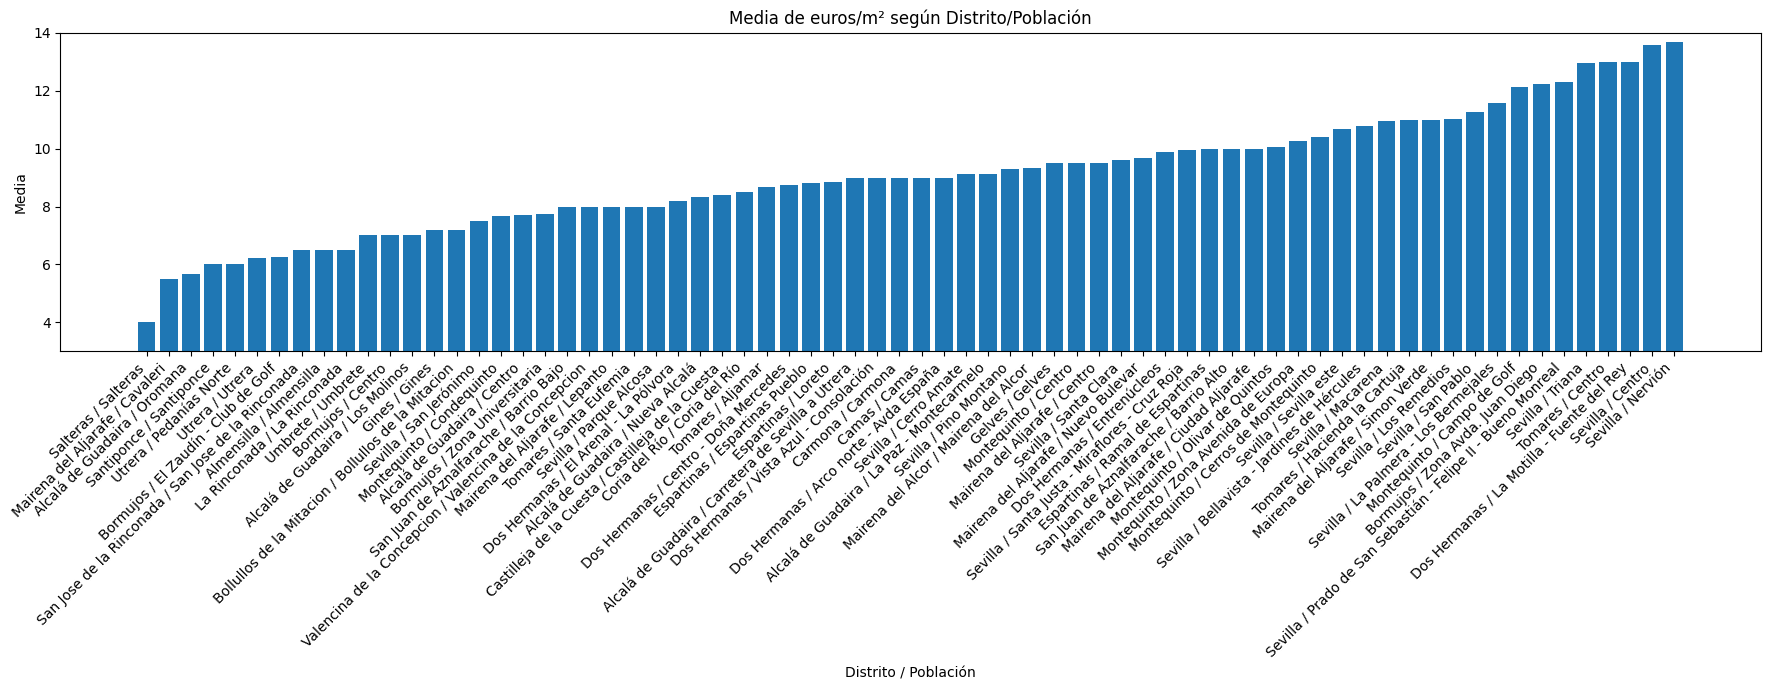

In [17]:
plt.figure(figsize=(18, 7))
plt.bar(grupo_ciudad_distrito['poblacion / distrito'], grupo_ciudad_distrito['mean'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Distrito / Población')
plt.ylabel('Media')
plt.title('Media de euros/m\u00B2 según Distrito/Población')
plt.ylim(3,14)
plt.tight_layout()

In [18]:
'''Añado las 3 categorias creadas a nuestra dataframe con un valor por defecto de 0'''
df['codigo_distrito'] = 0
df['poblacion / distrito'] = 0
df['precio_area / distrito'] = 0

In [19]:
'''Mediante un bucle for, voy recorriendo nuestra dataframe
y comparándola con la agrupada para añadir después los valores que correspondan
en cada columna creada'''
for i, municipio in enumerate(df['municipality']):
    if df['codigo_distrito'][i] == 0:
        for n, municipio_group in enumerate(grupo_ciudad_distrito['municipality']):
            if municipio_group == municipio:
                for w, distrito in enumerate(df['district']):
                    if w == i:
                        for p, distrito_group in enumerate(grupo_ciudad_distrito['district']):
                            if distrito_group == distrito and grupo_ciudad_distrito['municipality'][p] == municipio:
                                df['codigo_distrito'][i] = grupo_ciudad_distrito['codigo_distrito'][p]
                                df['poblacion / distrito'][i] = grupo_ciudad_distrito['poblacion / distrito'][p]
                                df['precio_area / distrito'][i] = grupo_ciudad_distrito['mean'][p]  

In [20]:
'''Compruebo que todos los distritos están codificados'''
df['codigo_distrito'].nunique()

70

In [21]:
df['detailedType'].value_counts()

detailedType
{'typology': 'flat'}                                          763
{'typology': 'chalet', 'subTypology': 'independantHouse'}      83
{'typology': 'flat', 'subTypology': 'penthouse'}               42
{'typology': 'chalet', 'subTypology': 'terracedHouse'}         34
{'typology': 'flat', 'subTypology': 'studio'}                  27
{'typology': 'flat', 'subTypology': 'duplex'}                  26
{'typology': 'chalet', 'subTypology': 'semidetachedHouse'}     13
{'typology': 'chalet'}                                          3
Name: count, dtype: int64

In [22]:
'''creamos columna para codificar el tipo de casa,
los códigos son asignados por la medias de sus precios de menor a mayor
- Estudio : 1
- Piso : 2
- Adosada : 3
- Duplex : 4
- Atico : 5
- Pareada : 6
- Independiente : 7
'''
df['codigo_tipo'] = 0

In [23]:
'''Mediante un bucle for, recorro todos los tipos de viviendas y le asigno el código correspondiente'''
for i, tipo in enumerate(df['detailedType']):
    variable = str(tipo)
    if variable == "{'typology': 'flat', 'subTypology': 'studio'}": 
        df['codigo_tipo'][i] = 1
    elif variable == "{'typology': 'flat'}": 
        df['codigo_tipo'][i] = 2
    elif variable == "{'typology': 'chalet', 'subTypology': 'terracedHouse'}": 
        df['codigo_tipo'][i] = 3
    elif variable == "{'typology': 'flat', 'subTypology': 'duplex'}": 
        df['codigo_tipo'][i] = 4
    elif variable == "{'typology': 'flat', 'subTypology': 'penthouse'}": 
        df['codigo_tipo'][i] = 5
    elif variable == "{'typology': 'chalet', 'subTypology': 'semidetachedHouse'}": 
        df['codigo_tipo'][i] = 6
    else: 
        df['codigo_tipo'][i] = 7

In [24]:
'''Ya que hay áticos en la categoría pisos,
busco en la descripciones, cual contiene la palabra ático, 
previeniendo cualquier error'''
for i, comment in enumerate(df['description']):
    if pd.notna(comment) and ('ático' in comment or 'atico' in comment or 'Ático' in comment or 'Atico' in comment):
        df['codigo_tipo'][i] = 5
   

In [25]:
grupo_tipo_vivienda = df.groupby(['codigo_tipo'],as_index=False)['price'].agg(['mean'])

In [26]:
grupo_tipo_vivienda['tipo_vivienda'] = ['Estudio','Piso','Adosada','Duplex','Atico','Pareada','Independiente']

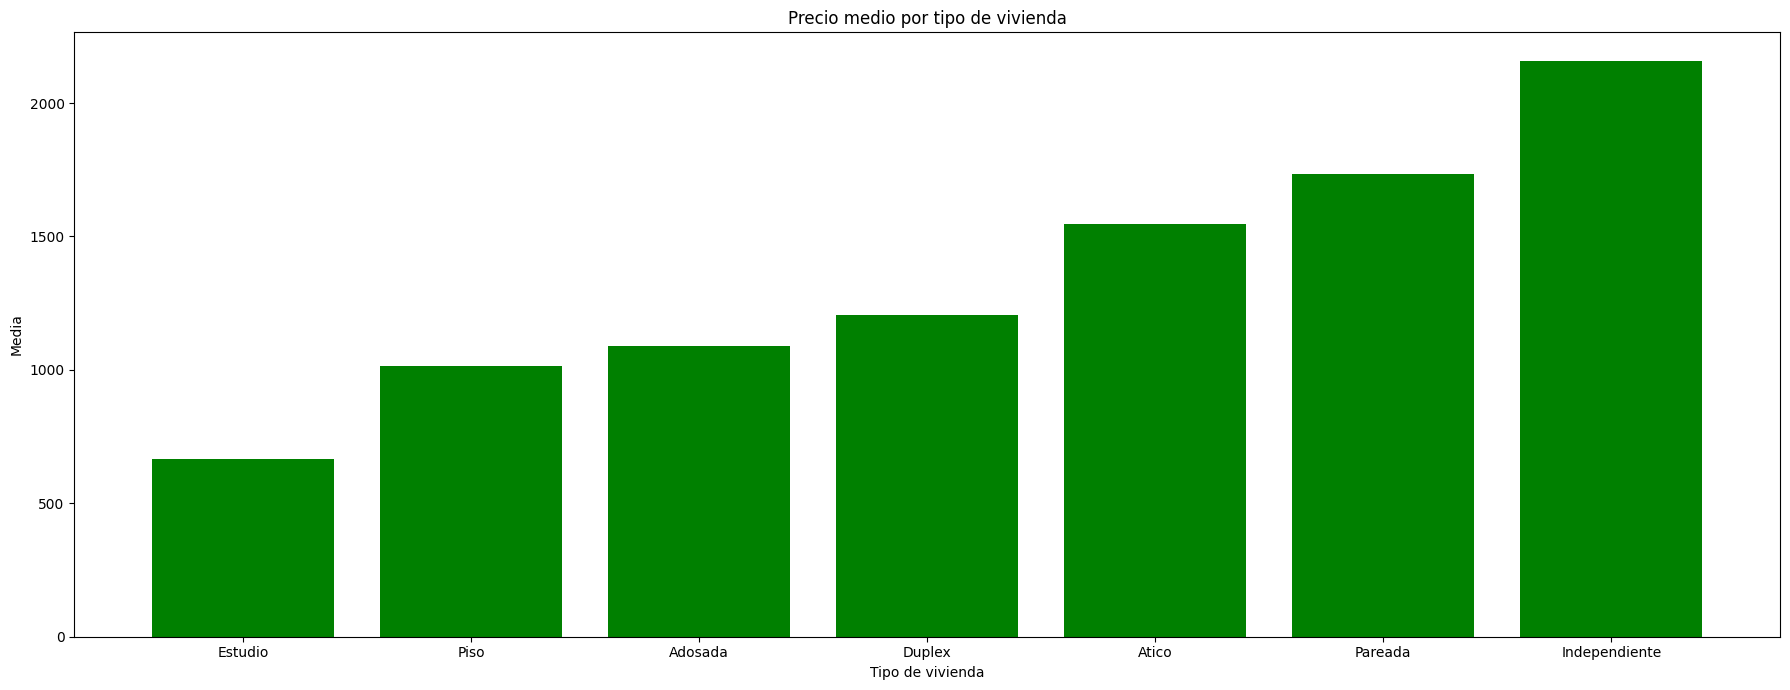

In [27]:
plt.figure(figsize=(18, 7))
plt.bar(grupo_tipo_vivienda['tipo_vivienda'], grupo_tipo_vivienda['mean'],color='green')
plt.xlabel('Tipo de vivienda')
plt.ylabel('Media')
plt.title('Precio medio por tipo de vivienda')
plt.tight_layout()

In [28]:
'''Compruebo las viviendas que tienen piscina.
Damos por hecho, que en los pisos, la piscina será común'''
df[(df['description'].notnull()) &  (df['description'].str.contains('piscina', case=False))].sort_values(by='price', ascending=False)

,propertyCode,floor,price,propertyType,size,exterior,rooms,bathrooms,address,municipality,...,priceByArea,detailedType,suggestedTexts,neighborhood,parkingSpace,parking,codigo_distrito,poblacion / distrito,precio_area / distrito,codigo_tipo
949,81660042,NaN,5300.0,chalet,449.0,NaN,4,4,Avenida Pan de Alcalá,Montequinto,...,12.0,"{'typology': 'chalet', 'subTypology': 'indepen...","{'subtitle': 'Campo de Golf, Montequinto', 'ti...",NaN,"{'hasParkingSpace': True, 'isParkingSpaceInclu...",1,63,Montequinto / Campo de Golf,12.142857,7
782,102213190,NaN,5000.0,chalet,419.0,NaN,6,5,Campo de Golf,Montequinto,...,12.0,"{'typology': 'chalet', 'subTypology': 'indepen...","{'subtitle': 'Campo de Golf, Montequinto', 'ti...",NaN,"{'hasParkingSpace': True, 'isParkingSpaceInclu...",1,63,Montequinto / Campo de Golf,12.142857,7
687,102552705,NaN,5000.0,chalet,494.0,NaN,6,6,Campo de Golf,Montequinto,...,10.0,"{'typology': 'chalet', 'subTypology': 'indepen...","{'subtitle': 'Campo de Golf, Montequinto', 'ti...",NaN,"{'hasParkingSpace': True, 'isParkingSpaceInclu...",1,63,Montequinto / Campo de Golf,12.142857,7
938,98417933,NaN,4900.0,chalet,405.0,NaN,5,4,Olivar de Quintos,Montequinto,...,12.0,"{'typology': 'chalet', 'subTypology': 'indepen...","{'subtitle': 'Olivar de Quintos, Montequinto',...",NaN,"{'hasParkingSpace': True, 'isParkingSpaceInclu...",1,52,Montequinto / Olivar de Quintos,10.066667,7
523,102825922,NaN,4500.0,chalet,375.0,NaN,6,5,Olivar de Quintos,Montequinto,...,12.0,"{'typology': 'chalet', 'subTypology': 'indepen...","{'subtitle': 'Olivar de Quintos, Montequinto',...",NaN,"{'hasParkingSpace': True, 'isParkingSpaceInclu...",1,52,Montequinto / Olivar de Quintos,10.066667,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,26423867,4,525.0,studio,40.0,True,0,1,Avenida Alcalde Luis Uruñuela,Sevilla,...,13.0,"{'typology': 'flat', 'subTypology': 'studio'}",{'subtitle': 'Alcalde L. Uruñuela - Palacio de...,Alcalde L. Uruñuela - Palacio de Congresos,"{'hasParkingSpace': True, 'isParkingSpaceInclu...",1,55,Sevilla / Sevilla este,10.666667,1
707,97906805,4,525.0,studio,35.0,True,0,1,Avenida Alcalde Luis Uruñuela,Sevilla,...,15.0,"{'typology': 'flat', 'subTypology': 'studio'}",{'subtitle': 'Alcalde L. Uruñuela - Palacio de...,Alcalde L. Uruñuela - Palacio de Congresos,"{'hasParkingSpace': True, 'isParkingSpaceInclu...",1,55,Sevilla / Sevilla este,10.666667,1
347,92416687,5,525.0,studio,40.0,True,0,1,Avenida Alcalde Luis Uruñuela,Sevilla,...,13.0,"{'typology': 'flat', 'subTypology': 'studio'}",{'subtitle': 'Alcalde L. Uruñuela - Palacio de...,Alcalde L. Uruñuela - Palacio de Congresos,"{'hasParkingSpace': True, 'isParkingSpaceInclu...",1,55,Sevilla / Sevilla este,10.666667,1
417,102940322,2,525.0,studio,35.0,True,0,1,Calle Administrador Gutierrez Anaya,Sevilla,...,15.0,"{'typology': 'flat', 'subTypology': 'studio'}",{'subtitle': 'Alcalde L. Uruñuela - Palacio de...,Alcalde L. Uruñuela - Palacio de Congresos,"{'hasParkingSpace': True, 'isParkingSpaceInclu...",1,55,Sevilla / Sevilla este,10.666667,1


In [29]:
'''Creo una función en la que compruebo si description,
contiene la palabra piscina.'''
def tiene_piscina(description):
    if pd.notna(description):  
        return 1 if 'piscina' in description.lower() else 0
    else:
        return 0

In [30]:
'''Creo la columna piscina y le aplico la función creada'''
df['piscina'] = df['description'].apply(tiene_piscina)

In [31]:
'''Compruebo que a las 234 viviendas le ha puesto 1'''
df['piscina'].value_counts()

piscina
0    757
1    234
Name: count, dtype: int64

In [32]:
'''Al igual que en la función anterior,
en esta compruebo si existe la palabra amueblado(2) o sin amueblar(0)
si no existe, le adjudicaremos un 1'''
def amueblado(description):
    if pd.notna(description):  
        if 'amueblado' in description.lower():
            return 2 
        elif 'sin amueblar' in description.lower():
            return 0
        else:
            return 1
    else:
        return 1

In [33]:
'''Creo la columna muebles y le aplico la función creada'''
df['muebles'] = df['description'].apply(amueblado)

In [34]:
'''Compruebo que se ha realizado correctamente'''
df['muebles'].value_counts()

muebles
1    584
2    315
0     92
Name: count, dtype: int64

In [35]:
'''Elimino columnas irrelevantes o que ya las he creado en otro formato.'''
df = df.drop(['municipality','address','district','showAddress','exterior','distance','suggestedTexts','neighborhood','floor','detailedType','newDevelopment','hasLift','parkingSpace'],axis=1)

In [36]:
'''Creo una dataframe solo con datos númericos'''
df_num = df[['size','rooms','bathrooms','codigo_distrito','parking','price','codigo_tipo','piscina', 'muebles']]

In [37]:
'''Creo una columna, donde unifico los baños y habitaciones,
para así evitar la multicolinealidad'''
df_num['total_rooms'] = df_num['bathrooms'] + df_num['rooms']
df_num.drop(['rooms','bathrooms'],axis=1,inplace=True)

In [38]:
'''Código para pasar precio(target) al final, 
para así analizar mejor el siguiente diagrama'''
df_num = df_num[[col for col in df_num.columns if col != 'price'] + ['price']]

<Axes: >

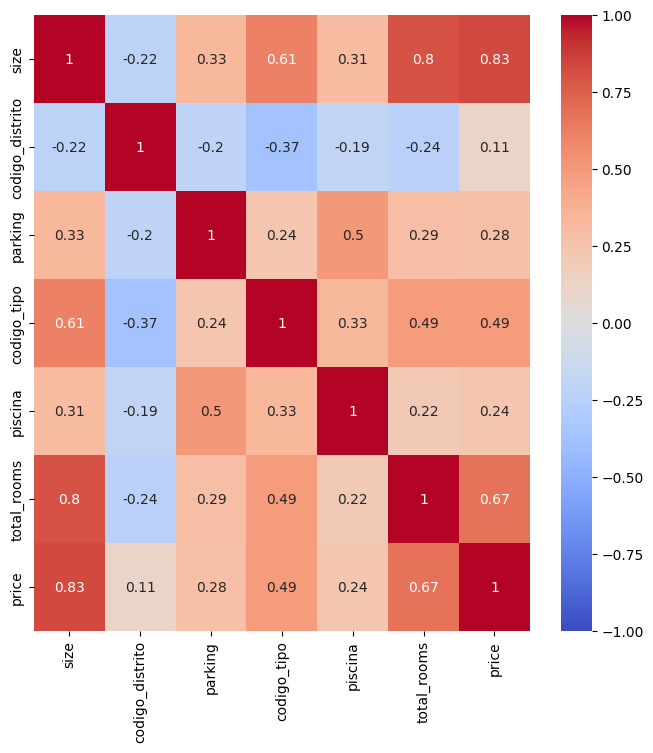

In [49]:
plt.figure(figsize=(8,8))
sns.heatmap(df_num.corr(),annot=True,vmin=-1,cmap='coolwarm')

In [56]:
nombres_categorias = [ 'Sin determinar', 'Amueblado','Sin amueblar',]

In [55]:
df['muebles'].value_counts()

muebles
1    584
2    315
0     92
Name: count, dtype: int64

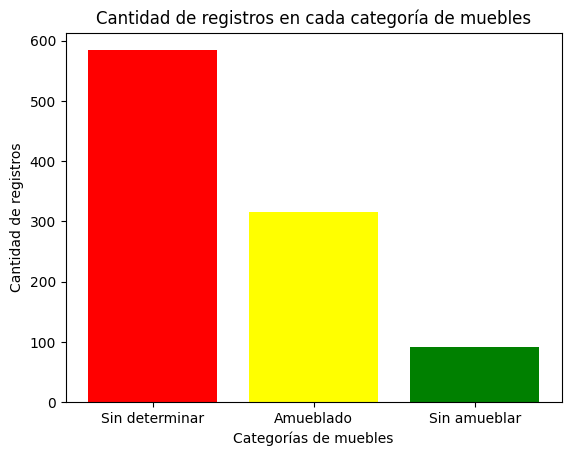

In [57]:
plt.bar(nombres_categorias, df['muebles'].value_counts(), color=['red', 'yellow', 'green'])
plt.xlabel('Categorías de muebles')
plt.ylabel('Cantidad de registros')
plt.title('Cantidad de registros en cada categoría de muebles')
plt.show()

Aún se observa multicolinealidad entre total_rooms y size, pero son 2 atributos importantes y que además, no mejora mi modelo el hecho de quitar alguno.

Parece que la columna muebles no correla mucho y además, empeora mi modelo. Seguramente será por haber tantos registros sin determinar, por lo que procedo a eliminarla


In [41]:
df_num.drop(['muebles'], axis=1, inplace=True)

<Figure size 800x800 with 0 Axes>

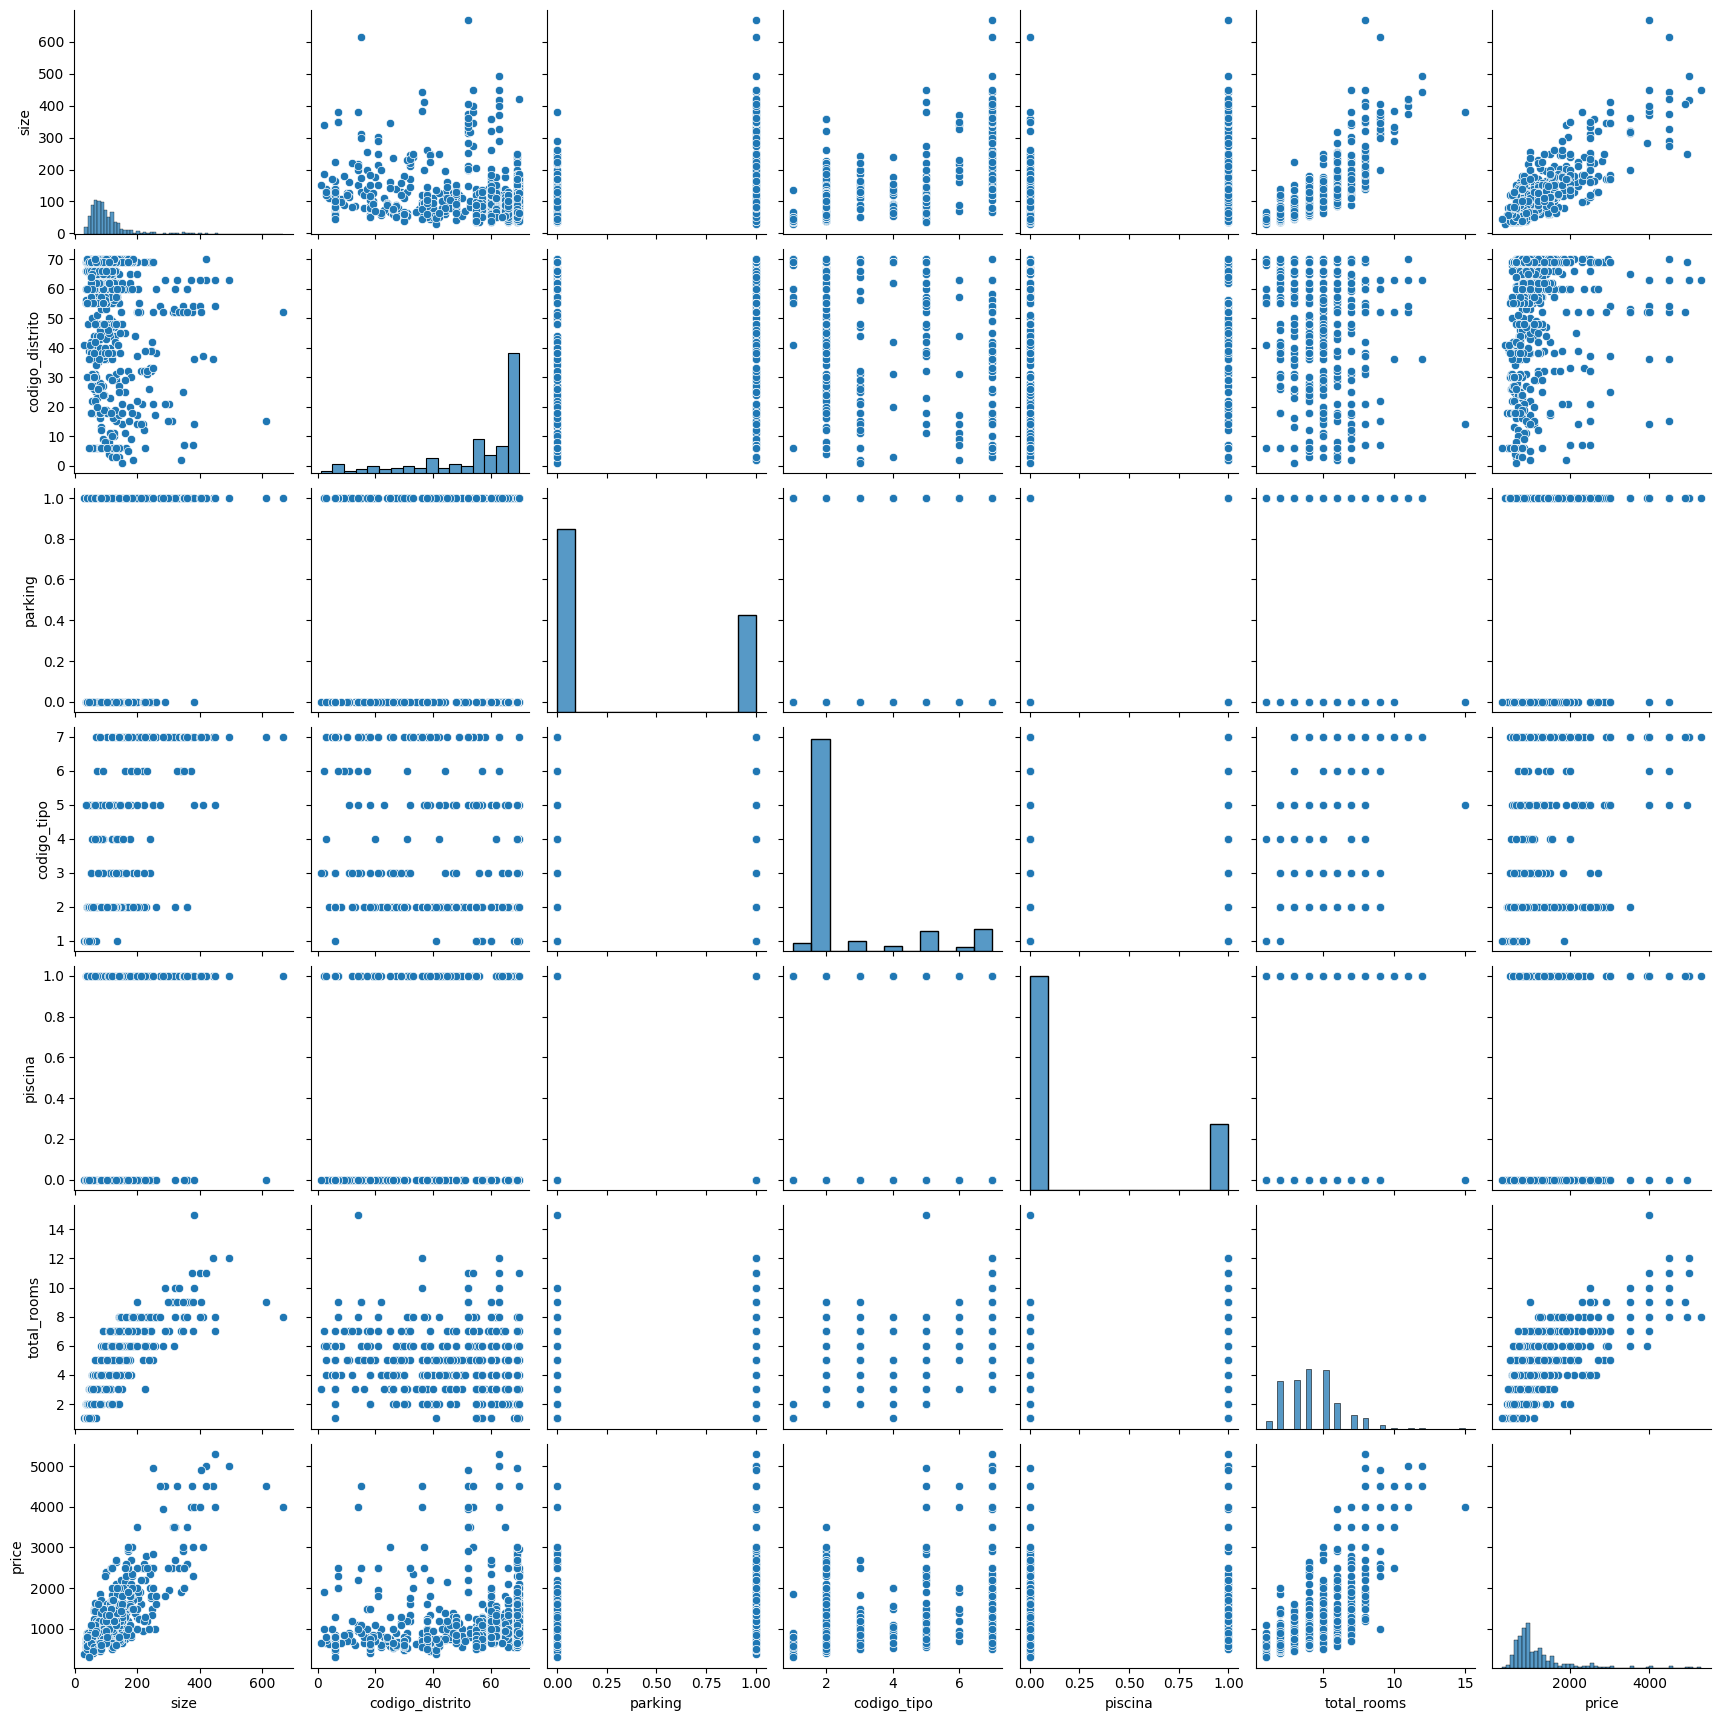

In [42]:
plt.figure(figsize=(8,8))
sns.pairplot(df_num)

Cosas que observamos en este pairplot:
- Efectivamente, se observa correlación entre size y total_rooms, ya que a mas tamaño, mas habitaciones y baños tendremos
- Se observa que, la viviendas con parking, son ligeramente mas caras que las viviendas sin parking
- A priori, el codigo_distrito, parece no tener correlación, ya que en cada distrito, hay viviendas de todo tipo, pero nos servirá para aproximarnos al precio según la localización de la vivienda.
- La distribucíon del código_distrito, se aprecia volcada a la derecha ya que la mayoria de zonas donde se alquilan pisos, son zonas centricas y por lo tanto mas caras son(centro, nervión, etc.)


### Split de las dataframe

In [43]:
from sklearn.model_selection import train_test_split

Creación de train y test

In [44]:
'''Una vez he terminado con el feature engineering,
divido la dataframe final en train y test entrenar y evaluar mi modelo.'''

df_train, df_test = train_test_split(df_num,test_size=0.15,random_state=10)

### Exportación de dataframes

In [45]:
df.to_csv(os.path.join(directorio_actual, '..', 'data','processed','df.csv'), index=False)
df_num.to_csv(os.path.join(directorio_actual, '..', 'data','processed','df_num.csv'), index=False)
df_train.to_csv(os.path.join(directorio_actual, '..', 'data','train','df_train.csv'), index=False)
df_test.to_csv(os.path.join(directorio_actual, '..', 'data','test','df_test.csv'), index=False)